In [70]:
import numpy as np 
import torch
import matplotlib.pyplot as plt

def generate_dataset(num_samples):
    dataset = []
    dot_product = []
    for i in range(num_samples):
        n = np.random.randint(2, 10)
        seq = torch.zeros((n, 2))
        idx1, idx2 = np.random.choice(n, size=2, replace=False)
        seq[idx1, 1] = 1
        seq[idx2, 1] = 1
        seq[:, 0] = torch.rand(n)
        dataset.append(seq) 
        sum = 0
        for i in range(n):
          sum = sum + seq[i][0]*seq[i][1]
        dot_product.append(sum)     
    return dataset, dot_product

dataset, dot_product = generate_dataset(5)

print(dataset[:1], dot_product[:1])

X,Y = generate_dataset(10)

[tensor([[0.1024, 1.0000],
        [0.9293, 1.0000],
        [0.2028, 0.0000],
        [0.4687, 0.0000],
        [0.4454, 0.0000]])] [tensor(1.0317)]


In [71]:
class ElmanRNN:
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Initialise weights
    self.Wxh = torch.rand([input_size, hidden_size], requires_grad = True)
    self.Whh = torch.rand([hidden_size, hidden_size], requires_grad = True) 
    self.Why = torch.rand([hidden_size, output_size], requires_grad = True)

    # Initialise biases
    self.bh = torch.rand(hidden_size, requires_grad=True)
    self.by = torch.rand(output_size, requires_grad=True)

    self.params = [self.Wxh, self.Whh, self.Why, self.bh, self.by]

  def forward(self, x):

    seq_len = len(x)
    
    # Initialize hidden state
    h = torch.zeros(self.hidden_size)

    for i in range(seq_len):
      # Compute hidden state
      h = torch.matmul(x[i],self.Wxh) + torch.matmul(h,self.Whh) + self.bh
      h = torch.tanh(h)

    # Compute output
    out = h * self.Why + self.by

    return out

  def backward(self, X, Y):
    optimizer = torch.optim.SGD(self.params, lr = 0.01 )
    n = len(X)
    train_loss = []
    num_epochs = 10

    for epoch in range(num_epochs):
      loss = 0
      epoch_loss = 0

      for i in range(n):
        y_pred = self.forward(X[i])
        y_true = Y[i]
        loss = (y_pred - y_true)**2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss

      train_loss.append(epoch_loss.item()/n)
      print(f'Loss of Elman RNN model at the end of epoch{epoch + 1} is {train_loss[epoch]}')

    return train_loss

In [72]:
model = ElmanRNN(2, 1, 1)
l1 = model.backward(X,Y)

Loss of Elman RNN model at the end of epoch1 is 0.2739530563354492
Loss of Elman RNN model at the end of epoch2 is 0.258932900428772
Loss of Elman RNN model at the end of epoch3 is 0.2521552085876465
Loss of Elman RNN model at the end of epoch4 is 0.24921486377716065
Loss of Elman RNN model at the end of epoch5 is 0.24802489280700685
Loss of Elman RNN model at the end of epoch6 is 0.2476071834564209
Loss of Elman RNN model at the end of epoch7 is 0.24751076698303223
Loss of Elman RNN model at the end of epoch8 is 0.24753341674804688
Loss of Elman RNN model at the end of epoch9 is 0.24758822917938234
Loss of Elman RNN model at the end of epoch10 is 0.24764089584350585


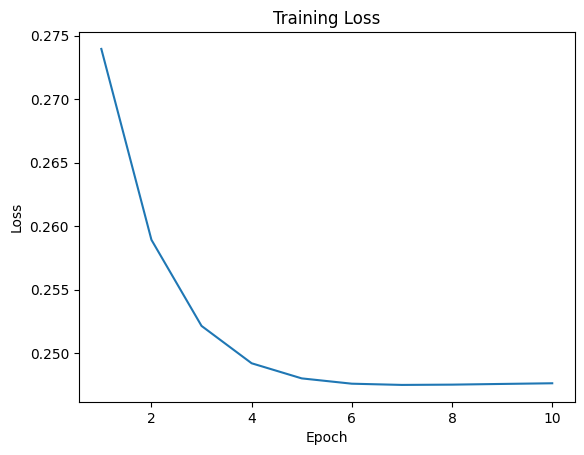

In [73]:
# plot learning curves
plt.plot(np.arange(1,11),l1)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [74]:
# Define LSTM model

class LSTM:
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size   
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Initialise weights
    self.Wf = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.Wi = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.Wc = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.Wo = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.V = torch.randn([hidden_size, output_size], requires_grad = True)

    # Initialise biases
    self.bf = torch.zeros(hidden_size, requires_grad=True)
    self.bi = torch.zeros(hidden_size, requires_grad=True)
    self.bc = torch.zeros(hidden_size, requires_grad=True)
    self.bo = torch.zeros(hidden_size, requires_grad=True)
    self.c = torch.zeros(hidden_size, requires_grad=True)

    self.params = [self.Wf, self.Wi, self.Wc, self.Wo, self.V, self.bf, self.bi, self.bc, self.bo]


  def forward(self, x): 

    seq_len = len(x)  

    # Initialize hidden state
    h = torch.zeros(self.hidden_size)

    for i in range(seq_len):
      conc_x = torch.cat((h,x[i]), 0)
      f = torch.sigmoid(torch.matmul(conc_x, self.Wf) + self.bf)
      i = torch.sigmoid(torch.matmul(conc_x, self.Wi) + self.bi)
      c_hat = torch.tanh(torch.matmul(conc_x, self.Wc)+ self.bc)
      c_t = torch.mul(f, self.c) + torch.mul(i, c_hat)
      o = torch.sigmoid(torch.matmul(conc_x, self.Wo) + self.bo)
      h_t = torch.mul(o, torch.tanh(c_t))
      h, self.c = h_t, c_t
      output = torch.matmul(h_t, self.V)
      return output

  def backward(self, X, Y):

    optimizer = torch.optim.SGD(self.params, lr = 0.01 )
    n = len(X)
    train_loss = []
    num_epochs = 10

    for epoch in range(num_epochs):
      loss = 0
      epoch_loss = 0

      for i in range(n):
        y_true = Y[i]
        y_pred =  self.forward(X[i])
        loss = (y_pred - y_true)**2
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

      epoch_loss += loss

      train_loss.append(epoch_loss.item()/n)
      print(f'Loss of LSTM model at the end of epoch{epoch + 1} is {train_loss[epoch]}')
  
    return train_loss



In [75]:
model = LSTM(2, 1, 1)
l2 = model.backward(X,Y)

Loss of LSTM model at the end of epoch1 is 0.1490995168685913
Loss of LSTM model at the end of epoch2 is 0.1451784610748291
Loss of LSTM model at the end of epoch3 is 0.14171555042266845
Loss of LSTM model at the end of epoch4 is 0.13864212036132811
Loss of LSTM model at the end of epoch5 is 0.1358786940574646
Loss of LSTM model at the end of epoch6 is 0.1333624839782715
Loss of LSTM model at the end of epoch7 is 0.13104304075241088
Loss of LSTM model at the end of epoch8 is 0.12887922525405884
Loss of LSTM model at the end of epoch9 is 0.12683701515197754
Loss of LSTM model at the end of epoch10 is 0.12488791942596436


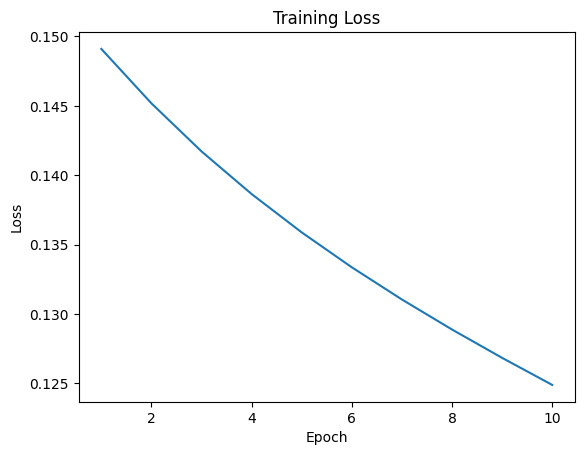

In [76]:
# plot learning curves
plt.plot(np.arange(1,11),l2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [77]:
# Define GRU model

class GRU:
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size   
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Initialise weights
    self.Wz = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.Wr = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.W = torch.randn([input_size + hidden_size, hidden_size], requires_grad = True)
    self.V = torch.randn([hidden_size, output_size], requires_grad = True)

    self.params = [self.Wz, self.Wr, self.W, self.V]


  def forward(self, x): 

    seq_len = len(x)  

    # Initialize hidden state
    h = torch.zeros(self.hidden_size)

    for i in range(seq_len):
      conc_x = torch.cat((h,x[i]), 0)
      z = torch.sigmoid(torch.matmul(conc_x, self.Wz))
      r = torch.sigmoid(torch.matmul(conc_x, self.Wr))
      conc_xr = torch.cat((torch.mul(r, h), x[i]), 0)
      h_hat = torch.tanh(torch.matmul(conc_xr, self.W))
      h = torch.mul(h, torch.sub(1, z)) + torch.mul(h_hat, z)
      output = torch.matmul(h, self.V)
      return output

  def backward(self, X, Y):

    optimizer = torch.optim.SGD(self.params, lr = 0.01 )
    n = len(X)
    train_loss = []
    num_epochs = 10

    for epoch in range(num_epochs):
      loss = 0
      epoch_loss = 0

      for i in range(n):
        y_true = Y[i]
        y_pred =  self.forward(X[i])
        loss = (y_pred - y_true)**2
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

      epoch_loss += loss

      train_loss.append(epoch_loss.item()/n)
      print(f'Loss of GRU model at the end of epoch{epoch + 1} is {train_loss[epoch]}')
  
    return train_loss



In [78]:
model = GRU(2, 1, 1)
l3 = model.backward(X,Y)

Loss of GRU model at the end of epoch1 is 0.06215270757675171
Loss of GRU model at the end of epoch2 is 0.055729740858078004
Loss of GRU model at the end of epoch3 is 0.049892523884773256
Loss of GRU model at the end of epoch4 is 0.044585767388343814
Loss of GRU model at the end of epoch5 is 0.0397655576467514
Loss of GRU model at the end of epoch6 is 0.035392659902572635
Loss of GRU model at the end of epoch7 is 0.03142866492271423
Loss of GRU model at the end of epoch8 is 0.027835294604301453
Loss of GRU model at the end of epoch9 is 0.024575288593769073
Loss of GRU model at the end of epoch10 is 0.02161414474248886


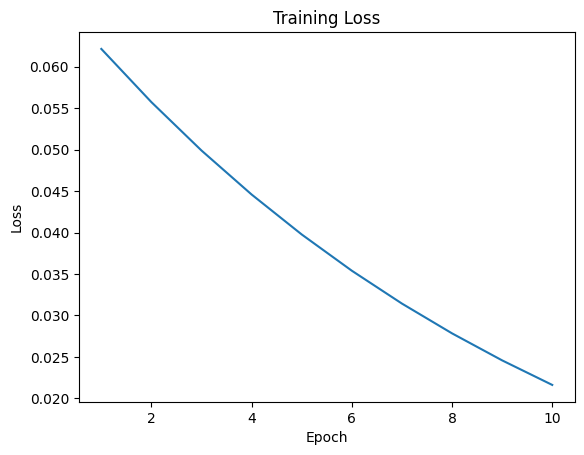

In [79]:
# plot learning curves
plt.plot(np.arange(1,11),l3)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [80]:
# Baseline model always predicts sum of 1
class Baseline:
  def __init__(self):
    pass

  def forward(self, x):
    return torch.tensor([1.0])

  def backward(self, X, Y):
    train_loss = []
    num_epochs = 10

    for epoch in range(num_epochs):
      loss = 0
      epoch_loss = 0

      for i in range(len(X)):
        y_pred = self.forward(X[i])
        y_true = Y[i]
        loss = (y_pred - y_true)**2
        epoch_loss += loss

      train_loss.append(epoch_loss.item()/len(X))
      print(f'Loss at the end of epoch{epoch + 1} is {train_loss[epoch]}')

    return train_loss



In [81]:
X,Y = generate_dataset(10)

model = ElmanRNN(2, 1, 1)
l1 = model.backward(X,Y)

model = LSTM(2, 1, 1)
l2 = model.backward(X,Y)

model = GRU(2, 1, 1)
l3 = model.backward(X,Y)

model = Baseline()
l = model.backward(X,Y)

Loss of Elman RNN model at the end of epoch1 is 0.4833041191101074
Loss of Elman RNN model at the end of epoch2 is 0.3843978404998779
Loss of Elman RNN model at the end of epoch3 is 0.3358262777328491
Loss of Elman RNN model at the end of epoch4 is 0.31224851608276366
Loss of Elman RNN model at the end of epoch5 is 0.3007920742034912
Loss of Elman RNN model at the end of epoch6 is 0.2950964212417603
Loss of Elman RNN model at the end of epoch7 is 0.29208083152770997
Loss of Elman RNN model at the end of epoch8 is 0.2902763605117798
Loss of Elman RNN model at the end of epoch9 is 0.28899297714233396
Loss of Elman RNN model at the end of epoch10 is 0.2879115104675293
Loss of LSTM model at the end of epoch1 is 0.2609739303588867
Loss of LSTM model at the end of epoch2 is 0.2535351991653442
Loss of LSTM model at the end of epoch3 is 0.24574871063232423
Loss of LSTM model at the end of epoch4 is 0.23742055892944336
Loss of LSTM model at the end of epoch5 is 0.22858684062957763
Loss of LSTM 

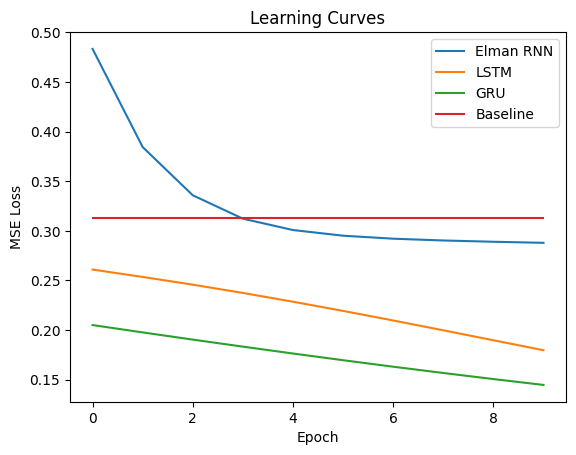

In [82]:
# Plot learning curves
plt.plot(l1, label='Elman RNN')
plt.plot(l2, label='LSTM')
plt.plot(l3, label='GRU')
plt.plot(l, label='Baseline')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()